In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import os
import json
import numpy as np
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [15]:
#defining transforms for the image

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

resnet_model = models.resnet50(weights=True)

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Modify the final fully connected layer
num_classes = 3  # Change this based on the number of classes in your dataset
in_features = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(in_features, num_classes)


In [17]:
#freeze weights 
for param in resnet_model.parameters():
    param.requires_grad = False

In [18]:
#dataset definition
dataset = datasets.ImageFolder(root='data', transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
#optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Training loop with progress printing
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.step()

        # Print statistics every, for example, 10 batches
        running_loss += loss.item()
        if i % 10 == 0:
            avg_loss = running_loss / 10
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i}/{len(dataloader)}], Loss: {avg_loss:.4f}')
            running_loss = 0.0

print('Training finished!')


Epoch [1/10], Batch [10/97], Loss: 1.0229
Epoch [1/10], Batch [20/97], Loss: 1.0443
Epoch [1/10], Batch [30/97], Loss: 1.0418
Epoch [1/10], Batch [40/97], Loss: 1.0344
Epoch [1/10], Batch [50/97], Loss: 1.0360
Epoch [1/10], Batch [60/97], Loss: 1.0288
Epoch [1/10], Batch [70/97], Loss: 1.0339
Epoch [1/10], Batch [80/97], Loss: 1.0493
Epoch [1/10], Batch [90/97], Loss: 1.0192
Epoch [2/10], Batch [10/97], Loss: 1.0343
Epoch [2/10], Batch [20/97], Loss: 1.0242
Epoch [2/10], Batch [30/97], Loss: 1.0492
Epoch [2/10], Batch [40/97], Loss: 1.0360
Epoch [2/10], Batch [50/97], Loss: 1.0459
Epoch [2/10], Batch [60/97], Loss: 1.0253
Epoch [2/10], Batch [70/97], Loss: 1.0549
Epoch [2/10], Batch [80/97], Loss: 1.0161
Epoch [2/10], Batch [90/97], Loss: 1.0392
Epoch [3/10], Batch [10/97], Loss: 1.0222
Epoch [3/10], Batch [20/97], Loss: 1.0418
Epoch [3/10], Batch [30/97], Loss: 1.0469
Epoch [3/10], Batch [40/97], Loss: 1.0417
Epoch [3/10], Batch [50/97], Loss: 1.0365
Epoch [3/10], Batch [60/97], Loss:

In [23]:
#show stats 
correct = 0
total = 0

with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()


print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')



Accuracy of the network on the 3074 test images: 53.903709411621094%


In [24]:
#save model
torch.save(resnet_model.state_dict(), 'model.pth')



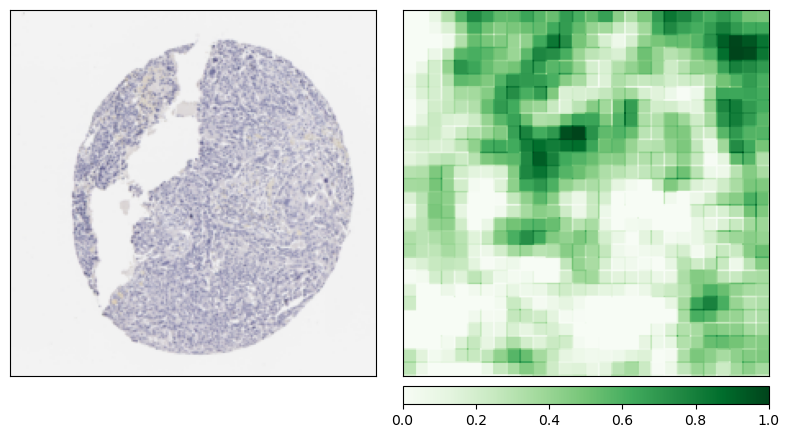

In [22]:
#captum occlusion-based 

occlusion = Occlusion(resnet_model)

# Occlusion visualization
test_image, test_label = dataset[0]
test_image = test_image.unsqueeze(0)
test_label = torch.tensor([test_label])

attributions_occ = occlusion.attribute(test_image,
                                        strides = (3, 8, 8),
                                        target = 1,
                                        sliding_window_shapes = (3,15, 15),
                                        baselines = 0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        np.transpose(test_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        ["original_image", "heat_map"],
                                        ["all", "positive"],
                                        show_colorbar = True,
                                        outlier_perc = 1)


